In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout, Concatenate,
    BatchNormalization, Add, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("FoodFactsCleaned.csv")
df["nutriscore_letter"] = df["nutriscore_letter"].astype(int)

In [ ]:
TEXT_COLS = [
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

TABULAR_COLS = [
    'nova_group', 'fat_100g',
    'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'contains_palm_oil', 'vegetarian_status', 'vegan_status',
    'nutrient_level_fat', 'nutrient_level_saturated_fat',
    'nutrient_level_sugars', 'nutrient_level_salt', 'ecoscore_grade', 'ecoscore_score',
    'carbon_footprint_100g', 'additives_count', 'sugar_ratio',
    'energy_density', 'protein_ratio', 'macro_balance', 'healthy_score',
    'log_energy_kcal_100g', 'log_salt_100g'
]

TARGET_COL = "nutriscore_letter"

RANDOM_STATE = 42
MAX_WORDS = 30000
MAX_LEN = 500

EPOCHS = 35
BATCH_SIZE = 64

In [280]:

for c in TEXT_COLS:
    df[c] = df[c].fillna("").astype(str)
df["text_concat"] = df[TEXT_COLS].agg(" ".join, axis=1)

X_text = df["text_concat"].values
X_tab  = df[TABULAR_COLS].values.astype(np.float32)
y = df[TARGET_COL].values

In [281]:
X_text_tv, X_text_te, X_tab_tv, X_tab_te, y_tv, y_te = train_test_split(
    X_text, X_tab, y,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y
)

In [282]:
X_text_tr, X_text_val, X_tab_tr, X_tab_val, y_tr, y_val = train_test_split(
    X_text_tv, X_tab_tv, y_tv,
    test_size=0.1765,
    random_state=RANDOM_STATE,
    stratify=y_tv
)

In [283]:

print("Train:", len(y_tr), "Val:", len(y_val), "Test:", len(y_te))

Train: 3596 Val: 771 Test: 771


In [284]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_tr)

def tok_pad(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")

X_text_tr_pad  = tok_pad(X_text_tr)
X_text_val_pad = tok_pad(X_text_val)
X_text_te_pad  = tok_pad(X_text_te)

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

In [285]:
num_classes = len(np.unique(y))

In [286]:
scaler = StandardScaler()
X_tab_tr_sc  = scaler.fit_transform(X_tab_tr).astype(np.float32)
X_tab_val_sc = scaler.transform(X_tab_val).astype(np.float32)
X_tab_te_sc  = scaler.transform(X_tab_te).astype(np.float32)

tab_dim = X_tab_tr_sc.shape[1]

print("Vocab:", vocab_size, "Tab dim:", tab_dim)

Vocab: 13832 Tab dim: 25


In [287]:
def build_early_fusion_model(vocab_size, max_len, tab_dim, num_classes):
    # Text input
    text_in = Input(shape=(max_len,), dtype=tf.int32, name="text_in")
    x_text = Embedding(vocab_size, 192, name="txt_embed")(text_in)
    x_text = SpatialDropout1D(0.25, name="txt_spdrop")(x_text)

    avg_pool = GlobalAveragePooling1D(name="txt_gap")(x_text)
    max_pool = GlobalMaxPooling1D(name="txt_gmp")(x_text)
    text_vec = Concatenate(name="txt_pool_concat")([avg_pool, max_pool])

    text_vec = Dense(256, activation="relu", name="txt_dense")(text_vec)
    text_vec = Dropout(0.35, name="txt_drop")(text_vec)

    # Tabular input
    tab_in = Input(shape=(tab_dim,), dtype=tf.float32, name="tab_in")
    tab_vec = Dense(256, activation="relu", name="tab_dense1")(tab_in)
    tab_vec = Dense(192, activation="relu", name="tab_dense2")(tab_vec)
    tab_vec = Dense(128, activation="relu", name="tab_dense3")(tab_vec)
    # Early fusion
    fused = Concatenate(name="early_fusion")([text_vec, tab_vec])

    # Fusion network
    x = Dense(512, activation="relu", name="fusion_dense1")(fused)
    x = BatchNormalization(name="fusion_bn1")(x)
    x = Dropout(0.40, name="fusion_drop1")(x)

    x = Dense(512, activation="relu", name="fusion_proj")(x)
    x = BatchNormalization(name="fusion_bn2")(x)
    x = Dropout(0.35, name="fusion_drop2")(x)

    x = Dense(256, activation="relu", name="fusion_dense2")(x)
    x = Dropout(0.3, name="fusion_drop3")(x)

    # Embedding for downstream classical models
    emb = Dense(256, activation="relu", name="final_embedding")(x)
    emb = BatchNormalization(name="final_emb_bn")(emb)
    emb = Dropout(0.3, name="final_emb_drop")(emb)

    out = Dense(num_classes, activation="softmax", name="out")(emb)

    model = Model(inputs=[text_in, tab_in], outputs=out, name="TextTab_EarlyFusion_Model5")
    return model


In [339]:
tf.keras.backend.clear_session()

In [340]:
nn_model = build_early_fusion_model(vocab_size, MAX_LEN, tab_dim, num_classes)

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

nn_model.summary()



Model: "TextTab_EarlyFusion_Model5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 220)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_embed           │ (None, 220, 192)  │  2,655,744 │ text_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_spdrop          │ (None, 220, 192)  │          0 │ txt_embed[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_gap             │ (None, 192)       │          0 │ txt_spdrop[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_gmp             │ (None, 192)       │          0 │ txt_spdrop[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_in (InputLayer) │ (None, 25)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_pool_concat     │ (None, 384)       │          0 │ txt_gap[0][0],    │
│ (Concatenate)       │                   │            │ txt_gmp[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_dense1 (Dense)  │ (None, 256)       │      6,656 │ tab_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_dense (Dense)   │ (None, 256)       │     98,560 │ txt_pool_concat[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_dense2 (Dense)  │ (None, 192)       │     49,344 │ tab_dense1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_drop (Dropout)  │ (None, 256)       │          0 │ txt_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_dense3 (Dense)  │ (None, 128)       │     24,704 │ tab_dense2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ early_fusion        │ (None, 384)       │          0 │ txt_drop[0][0],   │
│ (Concatenate)       │                   │            │ tab_dense3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense1       │ (None, 512)       │    197,120 │ early_fusion[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_bn1          │ (None, 512)       │      2,048 │ fusion_dense1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_drop1        │ (None, 512)       │          0 │ fusion_bn1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_proj (Dense) │ (None, 512)       │    262,656 │ fusion_drop1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_bn2          │ (None, 512)       │      2,048 │ fusion_proj[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_drop2        │ (None, 512)       │          0 │ fusion_bn2[0][0]  │
│ (Dropout)           │                   │            │                 

 Total params: 3,498,309 (13.34 MB)

 Trainable params: 3,495,749 (13.34 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [341]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.75, min_lr=1e-6)
]

history = nn_model.fit(
    {"text_in": X_text_tr_pad, "tab_in": X_tab_tr_sc},
    y_tr,
    validation_data=(
        {"text_in": X_text_val_pad, "tab_in": X_tab_val_sc},
        y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4836 - loss: 1.4302 - val_accuracy: 0.3567 - val_loss: 1.4210 - learning_rate: 5.0000e-04
Epoch 2/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6393 - loss: 0.9178 - val_accuracy: 0.4099 - val_loss: 1.2618 - learning_rate: 5.0000e-04
Epoch 3/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6685 - loss: 0.8085 - val_accuracy: 0.4617 - val_loss: 1.1375 - learning_rate: 5.0000e-04
Epoch 4/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7080 - loss: 0.7033 - val_accuracy: 0.5045 - val_loss: 0.9815 - learning_rate: 5.0000e-04
Epoch 5/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7266 - loss: 0.6532 - val_accuracy: 0.6355 - val_loss: 0.8048 - learning_rate: 5.0000e-04
Epoch 6/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7400 - loss: 0.6508 - val_accuracy: 0.7160 - val_loss: 0.6740 - learning_rate: 5.0000e-04
Epoch 7/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7481 

In [342]:
nn_test_loss, nn_test_acc = nn_model.evaluate(
    {"text_in": X_text_te_pad, "tab_in": X_tab_te_sc},
    y_te,
    verbose=0
)

print("\n=== NN (Early Fusion) TEST ===")
print("Test Accuracy:", nn_test_acc)
print("Test Macro-F1:", f1_score(y_te, np.argmax(nn_model.predict({"text_in": X_text_te_pad, "tab_in": X_tab_te_sc}, verbose=0), axis=1), average="macro"))




=== NN (Early Fusion) TEST ===
Test Accuracy: 0.8274967670440674
Test Macro-F1: 0.8261180532428885


In [343]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_te, np.argmax(nn_model.predict({"text_in": X_text_te_pad, "tab_in": X_tab_te_sc}, verbose=0), axis=1))
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[110  32   3   0   0]
 [ 12 124  11   1   0]
 [  2  18 133   4   0]
 [  1   0  24 117   6]
 [  0   0   0  19 154]]


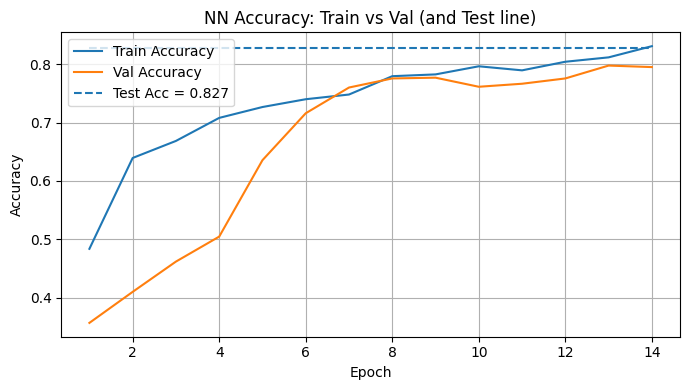

In [344]:
epochs = np.arange(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Val Accuracy")
plt.hlines(nn_test_acc, epochs[0], epochs[-1], linestyles="dashed", label=f"Test Acc = {nn_test_acc:.3f}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("NN Accuracy: Train vs Val (and Test line)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [345]:
embed_extractor = Model(
    inputs=nn_model.inputs,
    outputs=nn_model.get_layer("final_embedding").output
)

In [390]:
Z_tr  = embed_extractor.predict({"text_in": X_text_tr_pad,  "tab_in": X_tab_tr_sc},  batch_size=256, verbose=0)
Z_te  = embed_extractor.predict({"text_in": X_text_te_pad,  "tab_in": X_tab_te_sc},  batch_size=256, verbose=0)

print("Embeddings:", Z_tr.shape, Z_te.shape)


Embeddings: (3596, 256) (771, 256)


In [452]:
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.00005,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=7,
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [ ]:
xgb.fit(
    Z_tr, y_tr,
)

In [451]:
xgb_pred_tr  = xgb.predict(Z_tr)
xgb_pred_te  = xgb.predict(Z_te)

print("\n=== XGBoost on NN Embeddings ===")
print(f"Train Acc: {accuracy_score(y_tr, xgb_pred_tr):.4f}")
print(f"Test  Acc: {accuracy_score(y_te, xgb_pred_te):.4f}")
print("Test Macro-F1:", f1_score(y_te, xgb_pred_te, average="macro"))
print(classification_report(y_te, xgb_pred_te))




=== XGBoost on NN Embeddings ===
Train Acc: 0.8768
Test  Acc: 0.8508
Test Macro-F1: 0.8485772755313576
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       145
           1       0.80      0.80      0.80       148
           2       0.80      0.86      0.83       157
           3       0.85      0.83      0.84       148
           4       0.95      0.92      0.94       173

    accuracy                           0.85       771
   macro avg       0.85      0.85      0.85       771
weighted avg       0.85      0.85      0.85       771



In [306]:
svm = LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE)
svm.fit(Z_tr, y_tr)

svm_pred_tr  = svm.predict(Z_tr)
svm_pred_val = svm.predict(Z_val)
svm_pred_te  = svm.predict(Z_te)

In [307]:
print("\n=== Linear SVM on NN Embeddings ===")
print(f"Train Acc: {accuracy_score(y_tr, svm_pred_tr):.4f}")
print(f"Val   Acc: {accuracy_score(y_val, svm_pred_val):.4f}")
print(f"Test  Acc: {accuracy_score(y_te, svm_pred_te):.4f}")
print("Test Macro-F1:", f1_score(y_te, svm_pred_te, average="macro"))
print(classification_report(y_te, svm_pred_te))


=== Linear SVM on NN Embeddings ===
Train Acc: 0.9313
Val   Acc: 0.8054
Test  Acc: 0.8495
Test Macro-F1: 0.8477688968390578
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       145
           1       0.76      0.79      0.78       148
           2       0.82      0.83      0.83       157
           3       0.84      0.86      0.85       148
           4       0.97      0.91      0.94       173

    accuracy                           0.85       771
   macro avg       0.85      0.85      0.85       771
weighted avg       0.85      0.85      0.85       771



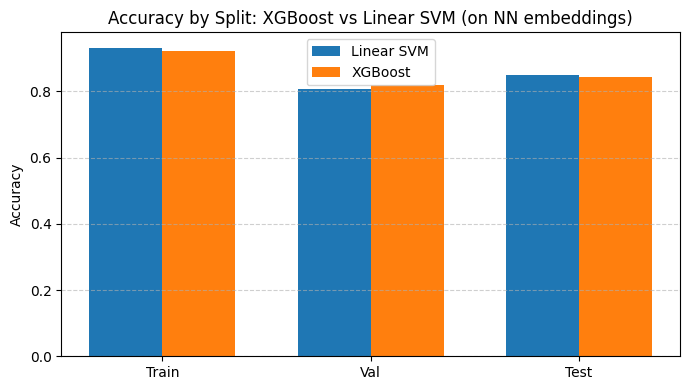

In [308]:
labels = ["Train", "Val", "Test"]

svm_acc = [
    accuracy_score(y_tr, svm_pred_tr),
    accuracy_score(y_val, svm_pred_val),
    accuracy_score(y_te, svm_pred_te)
]

xgb_acc = [
    accuracy_score(y_tr, xgb_pred_tr),
    accuracy_score(y_val, xgb_pred_val),
    accuracy_score(y_te, xgb_pred_te)
]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - w/2, svm_acc, w, label="Linear SVM")
plt.bar(x + w/2, xgb_acc, w, label="XGBoost")
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Accuracy by Split: XGBoost vs Linear SVM (on NN embeddings)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()